# Electricity Supply Analysis

In a country like Nigeria with no constant supply of electricity, this project is aimed at analyzing the supply of electricity in a neighbourhood.

In this project, I'll be performing analysis according to the electricity supply.

In [75]:
import datetime as dt
import json
import glob
import traces
import numpy as np
import pandas as pd
from matplotlib import  pyplot as plt

In [2]:
# Data sources
data_dir = "data/datasets/"

files = glob.glob(data_dir + "*.json")
data = pd.DataFrame()

In [3]:
def clean_time(time):
    return str(time).split()[1]

### Load and clean data

In [4]:
temp = []

# load data from json files
for file in files:
    read = json.load(open(file))
    temp.append(pd.DataFrame(read))

# append to ultimate dataframe
data = pd.concat(temp, ignore_index=True)

# format to datetime for sorting
data['opendate'] = pd.to_datetime(data['opendate'], format="%Y-%m-%d")
data['opentime'] = pd.to_datetime(data['opentime'], format="%H:%M:%S")
data['remarks'] = pd.to_timedelta(data['diff']).dt.seconds

# clean date attribute
data['opentime'] = data['opentime'].apply(lambda x: clean_time(x))
data['opendatetime'] = data['opendate'].astype(str) + " " + data['opentime'].astype(str)
data['closedatetime'] = data['closedate'].astype(str) + " " + data['closetime'].astype(str)

data['opendatetime'] = pd.to_datetime(data['opendatetime'])
data['closedatetime'] = pd.to_datetime(data['closedatetime'])
data = data.reindex(columns=["opendatetime", "opendate", "opentime", "closedatetime", "closedate", "closetime","diff", "remarks"])

# sort by opening date and opentime
data = data.sort_values("opendate")
data = data.reset_index(drop=True)

data.to_csv(data_dir + "data.csv", index=False)

In [5]:
data.tail()

,opendatetime,opendate,opentime,closedatetime,closedate,closetime,diff,remarks
292,2022-09-18 00:28:34,2022-09-18,00:28:34,2022-09-18 02:50:26,2022-09-18,02:50:26,2:21:52,8512
293,2022-09-19 07:39:41,2022-09-19,07:39:41,2022-09-19 13:37:46,2022-09-19,13:37:46,5:58:05,21485
294,2022-09-19 16:22:59,2022-09-19,16:22:59,2022-09-19 17:12:53,2022-09-19,17:12:53,0:49:54,2994
295,2022-09-19 00:11:42,2022-09-19,00:11:42,2022-09-19 04:49:06,2022-09-19,04:49:06,4:37:24,16644
296,2022-09-19 22:31:41,2022-09-19,22:31:41,2022-09-20 02:26:07,2022-09-20,02:26:07,3:54:26,14066


### Number of occurrence of electricity supply?

In [6]:
data.shape

(297, 8)

- There were 297 occurrence of electricity from August to September

### What data types are contained in the dataset?

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   opendatetime   297 non-null    datetime64[ns]
 1   opendate       297 non-null    datetime64[ns]
 2   opentime       297 non-null    object        
 3   closedatetime  297 non-null    datetime64[ns]
 4   closedate      297 non-null    object        
 5   closetime      297 non-null    object        
 6   diff           297 non-null    object        
 7   remarks        297 non-null    int64         
dtypes: datetime64[ns](3), int64(1), object(4)
memory usage: 18.7+ KB


- There is only one numeric variable and 7 discrete datetime objects

### Does the dataset contain null values?

In [8]:
data.isna().sum()

opendatetime     0
opendate         0
opentime         0
closedatetime    0
closedate        0
closetime        0
diff             0
remarks          0
dtype: int64

- The dataset has no null value

### Which day had the most supply of electricity?

In [9]:
# describe the data and determine the maximum day
desc = data.describe().T
data.loc[(data['remarks'] == int(desc['max'].iloc[-1]))]

,opendatetime,opendate,opentime,closedatetime,closedate,closetime,diff,remarks
68,2022-07-20 13:53:43,2022-07-20,13:53:43,2022-07-20 19:52:29,2022-07-20,19:52:29,5:58:46,21526


- 20th of July had the most supply with 6 hours of electricity

### Which day had the least supply of electricity?

In [10]:
data.loc[(data['remarks'] == int(desc['min'].iloc[-1]))]

,opendatetime,opendate,opentime,closedatetime,closedate,closetime,diff,remarks
28,2022-07-08 20:55:27,2022-07-08,20:55:27,2022-07-08 21:25:57,2022-07-08,21:25:57,0:30:30,1830


- 7th of July had the least supply with only 30.6 minutes of supply (No flashing)

### On average, how long does the supply last?

In [11]:
# display data description and convert seconds to hours
desc = (desc.reindex(columns=["mean", "std", "min", "50%", "max"]) / 60 / 60).round(decimals=2)
desc

,mean,std,min,50%,max
remarks,3.25,1.59,0.51,3.24,5.98


- The average supply lasts about 3.25 hours of electricity

## Univariate and Time Series Analysis

In [12]:
time_series = traces.TimeSeries()

# append open and close datetime to time series
for row in data.values:
    time_series[row[0]] = "ON"
    time_series[row[3]] = "OFF"

### Were there more ONs than OFFs?

Histogram({'OFF': 50.21, 'ON': 49.79})


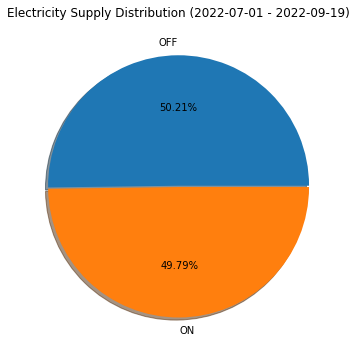

In [73]:
# calculate fraction of time for the time series
distribution = time_series.distribution(
        start=data.values[0][0],
        end=data.values[-1][0]
)

# convert decimals to percents
distribution['OFF'] = round(distribution['OFF'] * 100, 2)
distribution['ON'] = round(distribution['ON'] * 100, 2)
print(distribution)

# plot histogram distribution
fig = plt.figure(figsize=(8, 6))
plt.pie(distribution.values(), autopct="%.2f%%",
                         labels= ["OFF", "ON"], shadow=True,
                         explode=(0,0.01))

# append labels to plot
plt.title(f"Electricity Supply Distribution ({str(data.values[0][0]).split()[0]} - "
        f"{str(data.values[-1][0]).split()[0]})")

# display plot
plt.show()

- There was no light for most of the time. Electricity was supplied only about 49% of the time.

### What times of the day had the most and least supply of electricity?

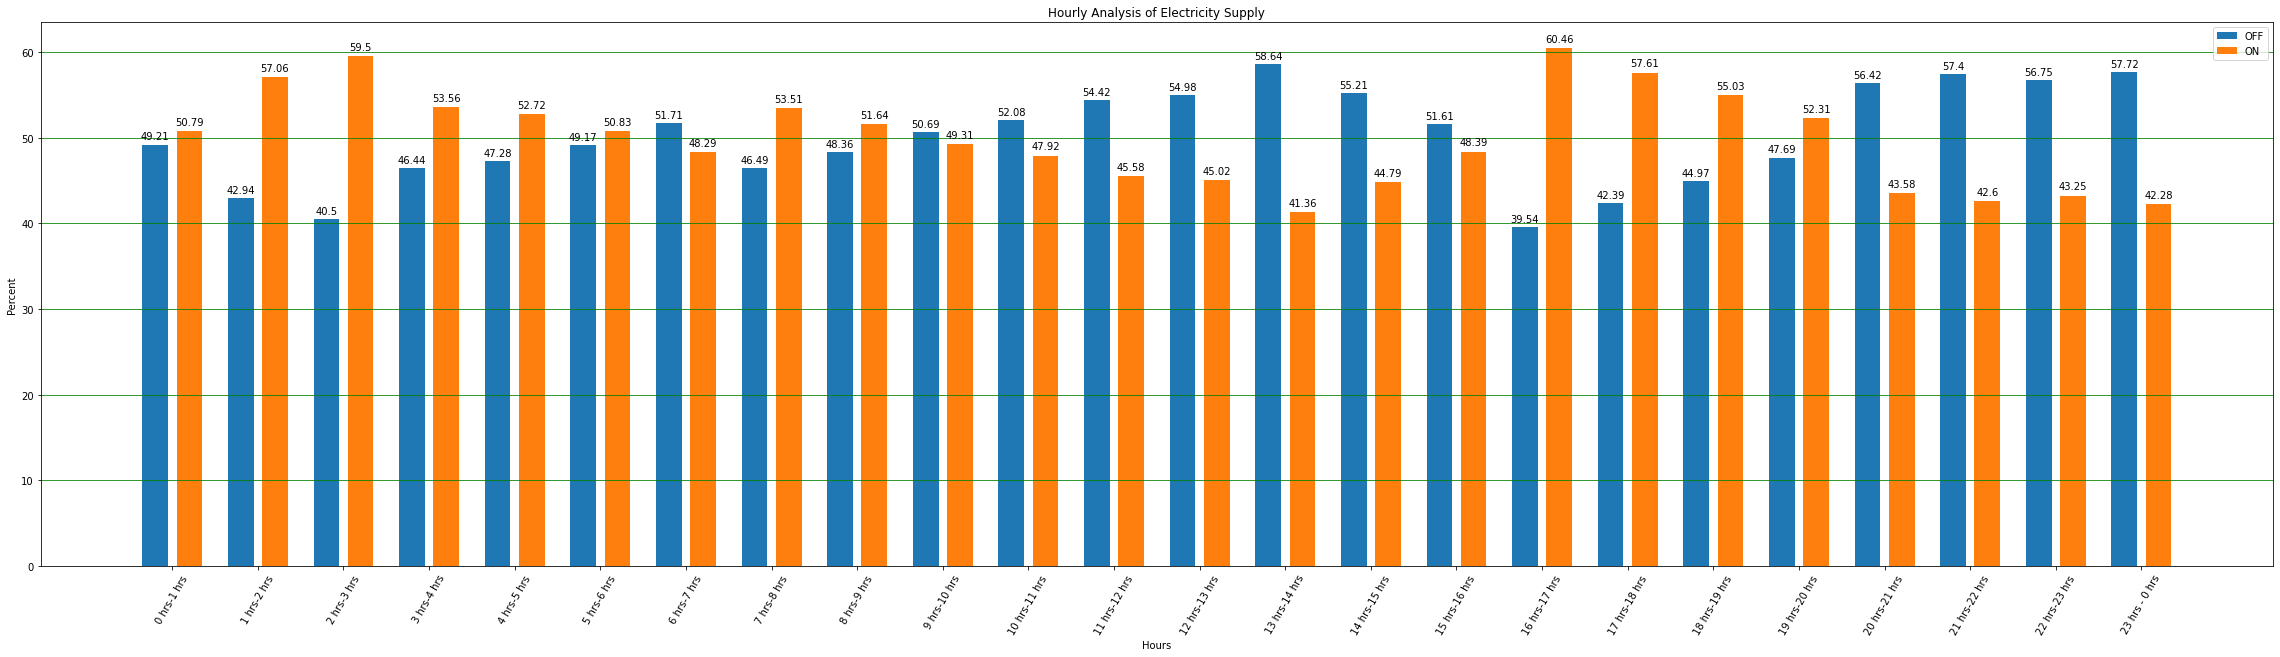

In [40]:
hours = time_series.distribution_by_hour_of_day()

# plot labels
ticks = [f"{i} hrs-{i+1} hrs" for i in range(0,23)]
ticks.append("23 hrs - 0 hrs")

# placeholder for hours of the day
hour_distribution = np.arange(24)

off = []
on = []

# iterate timeseries
for hour, dist in hours:
    off.append(round(dist['OFF'] * 100, 2))
    on.append(round(dist['ON'] * 100, 2))

# create figure and and bar plot
fig = plt.figure(figsize=(40, 10))
bar1 = plt.bar(hour_distribution-0.2, off, 0.3)
bar2 = plt.bar(hour_distribution+0.2, on, 0.3)

# annotate bar plot
plt.bar_label(bar1, padding=3)
plt.bar_label(bar2, padding=4)

# plot labelling
plt.title("Hourly Analysis of Electricity Supply")
plt.xlabel("Hours")
plt.ylabel("Percent")
plt.xticks(hour_distribution, ticks, rotation="60")

# plot visualization
plt.legend(["OFF", "ON"])
plt.grid(axis='y', color='green')
plt.show()

- Electricity supply was on the most between 4pm - 5 pm.
- Electricity supply was off the most between 1pm - 2pm.

### What days of the week had the most and least supply of electricity?

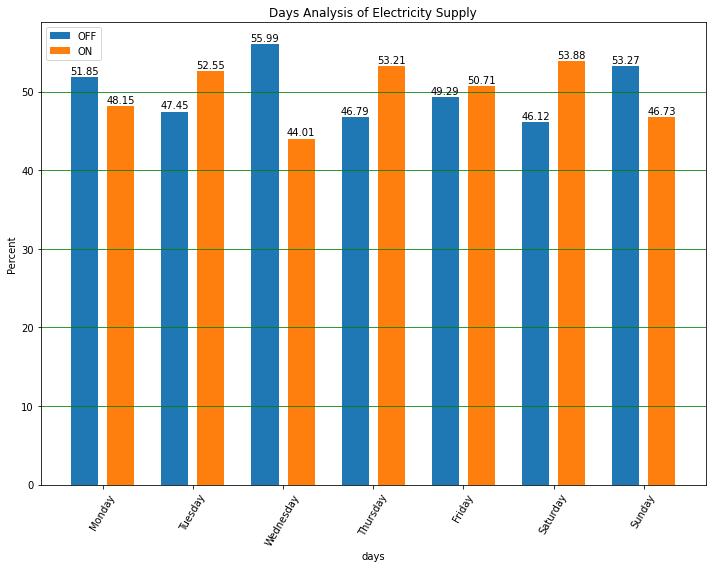

In [39]:
days = time_series.distribution_by_day_of_week()

# plot labels
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 
                'Thursday', 'Friday', 'Saturday', 'Sunday']

# placeholder for days of the day
day_distribution = np.arange(7)

off = []
on = []

# iterate timeseries
for day, dist in days:
    off.append(round(dist['OFF'] * 100, 2))
    on.append(round(dist['ON'] * 100, 2))

# create figure and and bar plot
fig = plt.figure(figsize=(10, 8))
bar1 = plt.bar(day_distribution-0.2, off, 0.3)
bar2 = plt.bar(day_distribution+0.2, on, 0.3)

# annotate bar plot
plt.bar_label(bar1, padding=1)
plt.bar_label(bar2, padding=1)

# plot labelling
plt.title("Days Analysis of Electricity Supply")
plt.xlabel("days")
plt.ylabel("Percent")
plt.xticks(day_distribution, days_of_week, rotation="60")

# plot visualization
plt.tight_layout()
plt.legend(["OFF", "ON"], loc="upper left")
plt.grid(axis='y', color='green')
plt.show()

- There was more electricity supply on Saturdays
- Electricity supply was off the most on Wednesdays.